# For Demo run through
- We first showcase the whole final project (import the pre-trained CNN) (this file -- **171_finalProject.ipynb**)
- Then we switch to our **cnn.ipynb** and show the training and EDA process on that file

---------

# Introduction
* The **first major** part of this .ipynb file will showcase our workflow process. It will run through a simple example throughout each step. It contains the following:
  * Defining class for image segmentation
  * Training our CNN model on images 
    * Our CNN model will be trained locally on the cnn.ipynb file since bringing the dataset into google drive is cumbersome.
    * **Exploratory Data Analysis** is performed on the cnn.ipynb file as well since dataset is loaded there.
    * In this file, we will simply load our saved model. Again, please check cnn.ipynb for cnn training.
  * Defining and constructing our parser
  * Attemtping to use a solver to finally solve the parsed expression

* The **second major** part of this .ipynb file will attempt to call all of the functions at once on a separate image so we can run tests quickly and smoothly without running 40 cells.

* Keep in mind, this is a simplified .ipynb file. Much of our development and testing were done on the other .ipynb files. In order to clean things up, we moved our final techniques/tests that worked best into this .ipynb file.

* Lastly, we have a front/back-end which we can use to run the whole process instantly. Please see the front/back-end folders.

# The Dataset
- [HASYv2](https://www.kaggle.com/datasets/guru001/hasyv2) (mathematical symbols)
  * Contains symbols, numbers, alphabet, etc. 


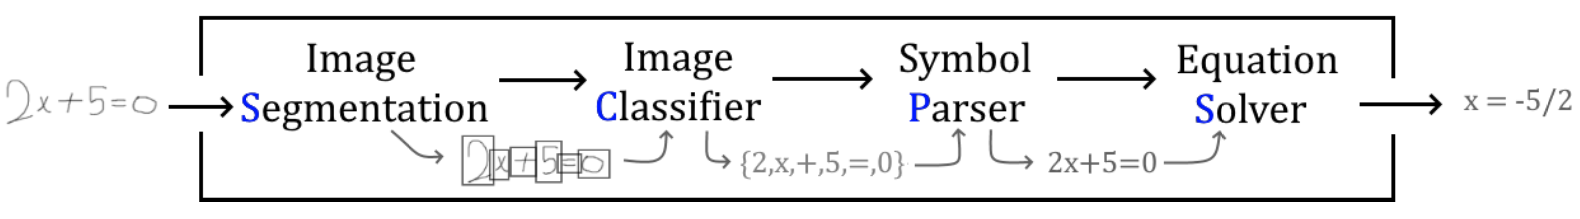

# Preliminaries

Import libraries and mount drive!
- We will import libraries, and mount our drive so we can access the 171 project folder
- Please add the folder to your drive by pressing 'add shortcut to folder to drive'
- If you are running locally, make sure to remove the mount drive lines

Import Libraries

In [1]:
# Import the necessary packages

# image segmentation
import os
import argparse
import cv2
import pandas as pd
import numpy as np
import functools
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import glob

# image classification
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import img_to_array
import pprint
import pickle 

# symbol parser and equation solver
from sympy import symbols
from sympy import Eq
from sympy.solvers import solve
from sympy.abc import x, y, z

Connect to Folder

In [2]:
# make sure you change this as necessary
def useGoogleDrive():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)


  # teaden's
  folder_path = '/content/gdrive/My Drive/ECS171_Term_Project'
  
  # old 
  # folder_path = '/content/gdrive/My Drive/ECS 171/ECS 171 - Term Project/'

  return folder_path

def useLocal():
  return "folderNameHere"


# folder_path = useLocal()
folder_path = useGoogleDrive()

Mounted at /content/gdrive


# (1) Image Segmentation
- Details are in the image_segmentation.ipynb file
- Image segmentation works by using image contours (no ML model, just image processing)
- The imageSegment class achieves the following:
  - creates contours of the image
  - returns the contoured version of the image
  - returns the actual newly generated segments of the images based on the contours
  - returns the bounding boxes of the segments

Define Segment Class

In [3]:
# we create the image segment class with various functions
# we have three visualizing/plotting functionbs, and one main segment function
class imageSegment:
  def __init__(self):
    return

  # a simple plot function to visualize original image and new image with bounding boxes
  def plotBeforeAfter(self, oldImage, newImage, boundingBoxes):

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # creates a grid of 1 row and 2 columns

    ax[0].imshow(newImage, cmap="gray")  # plots on the first subplot
    ax[0].set_title("Contoured")  # sets the title of the first subplot

    for bbox in boundingBoxes:
        # draw rectangle on the first subplot (contoured image)
        # bbox is a tuple with format (x, y, width, height)
        rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=2)
        ax[0].add_patch(rect)

    ax[0].axis('off')  # hide the axis on first subplot

    ax[1].imshow(oldImage, cmap="gray")  # plots on the second subplot
    ax[1].set_title("Old")  # sets the title of the second subplot
    ax[1].axis('off')  # hide the axis on second subplot

    plt.tight_layout()
    plt.show()
    return

  # print out bounding box details
  def boundingBoxDetails(self, boundingBox):
    print("Bounding boxes")
    for i in range(len(boundingBox)):
      print("Segment",str(i+1)+":",str(boundingBox[i]))

  # plot the segmented images
  def plotSegmentedImages(self, segmentedImages, max_images_per_row=5):

    # calculate the number of rows needed
    num_rows = len(segmentedImages) // max_images_per_row
    if len(segmentedImages) % max_images_per_row:
        num_rows += 1

    # create grid of subplots
    fig, axs = plt.subplots(num_rows, max_images_per_row, figsize=(10, 2*num_rows))

    # to handle case of single row or single column, we ensure axs is always a 2-D array
    if axs.ndim == 1:
        axs = axs.reshape(num_rows, -1)

    # loop through each image and display it on the subplot
    for i, img in enumerate(segmentedImages):
        row = i // max_images_per_row
        col = i % max_images_per_row
        axs[row, col].imshow(img, cmap='gray')
        axs[row, col].set_title('Contour {}'.format(i))
        # axs[row, col].axis('off')

    # if there are any empty subplots at the end, we hide them
    for j in range(i+1, num_rows*max_images_per_row):
        row = j // max_images_per_row
        col = j % max_images_per_row
        # axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

  # run segmentation model on a image given filename
  def segmentationModel(self, fileName=str()):

        # example filename
        # filename = "test_image/testImage_hard.png"

        # read the image and turn to grayscale
        image = cv2.imread(fileName)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # perform thresholding to create a binary image (Otsu's Method)
        _, binary = cv2.threshold(gray, 0, 255,
                                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        # find contours with hierarchy
        contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
        
        # generate bounding boxes based on contours
        boundingBoxes = [cv2.boundingRect(c) for c in contours]

        # sort cnts and bounding box from left to right
        contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])
        boundingBoxes = sorted(boundingBoxes, key=lambda x: x[0])

        # create an array to store segmented images
        segmentedImages = []
        contourOnImage = image.copy()
        _ = cv2.drawContours(contourOnImage, contours, -1, (0, 255, 0), 3)

        # iterate over the contours and hierarchy information
        for i, contour in enumerate(contours):
            # check if contour is an external contour (no parent)
            if hierarchy[0][i][3] == -1:
                
                # create a blank mask image
                mask = np.zeros_like(image)

                # draw the contour on the mask
                cv2.drawContours(mask, contours, i, (255, 255, 255), cv2.FILLED)

                # apply the mask to the original image
                segmented_image = cv2.bitwise_and(image, mask)
                segmented_image[mask == 0] = 255

                # store the segmented image in the array
                segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
                segmented_image[segmented_image >= 150] = 255
                segmented_image[segmented_image < 150] = 0

                # append the segmented image to our image list
                segmentedImages.append(segmented_image[boundingBoxes[i][1]:boundingBoxes[i][1]+boundingBoxes[i][3], boundingBoxes[i][0]:boundingBoxes[i][0]+boundingBoxes[i][2]])

        # return old image, contoured image, segmentedImages, and bounding boxes
        return image, contourOnImage, segmentedImages, boundingBoxes

Print our images in current imageFolder (test images we can run through)

In [4]:
# print out all the images we can run through

# set imageFolder name
imageFolder = 'testSegmentImages'

full_path = folder_path + '/' + imageFolder
if os.path.isdir(full_path):
    # List all files in the directory
    file_names = os.listdir(full_path)
    print(file_names)
else:
    print(f"The directory {full_path} does not exist.")

['test_handwritten.jpg', 'test_simple.png', 'test_simple2.png', 'test_thin.png', 'test_ez2.png', 'test_ez.png', 'test_sqrt.png', 'test_ez3.png', 'test_med1.png', 'test_med2.png', 'test2.png']


Testing/showcase of the segmentation

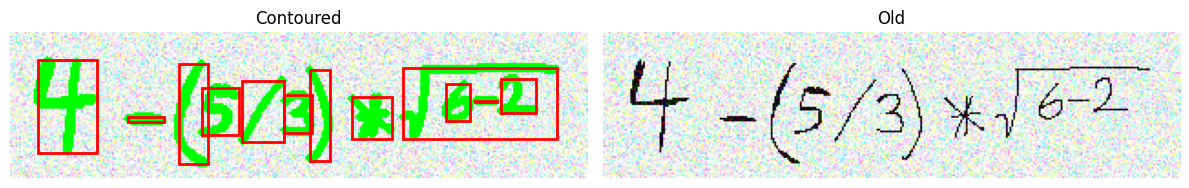

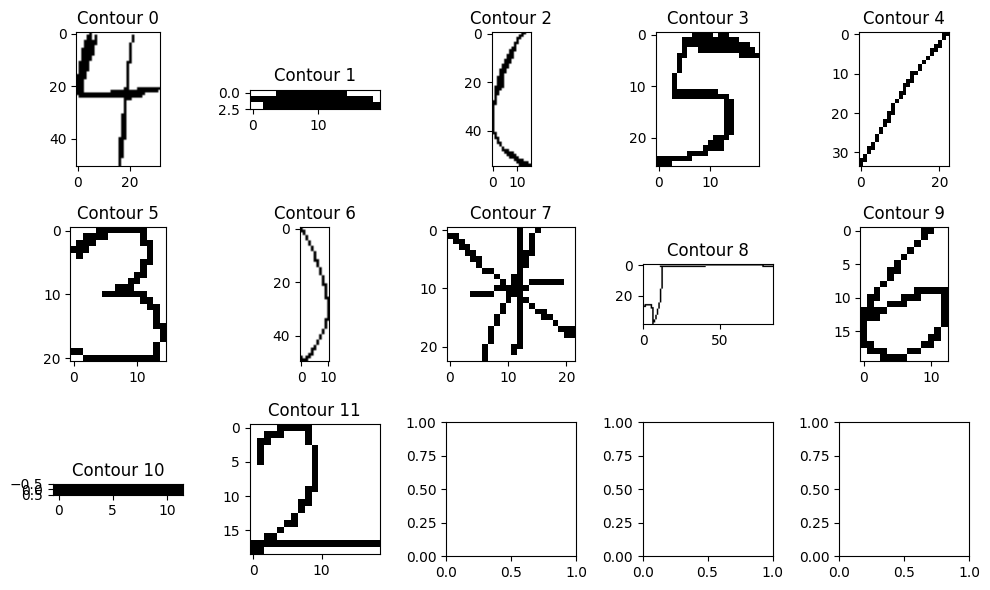

Bounding boxes
Segment 1: (15, 15, 32, 51)
Segment 2: (64, 46, 20, 3)
Segment 3: (92, 17, 16, 55)
Segment 4: (105, 30, 20, 26)
Segment 5: (127, 26, 23, 34)
Segment 6: (150, 34, 15, 21)
Segment 7: (164, 20, 11, 50)
Segment 8: (187, 35, 22, 23)
Segment 9: (215, 19, 85, 39)
Segment 10: (239, 28, 13, 20)
Segment 11: (255, 37, 12, 1)
Segment 12: (269, 25, 19, 19)
Boundary boxes are : (x,y,w,h) = (x_1, y_1, x_2 = x_1+w, y_1+h) where x_1 = left-most x, y_1 = left-most y, etc.


In [5]:
imageFolder = 'testSegmentImages'
fileName = "test2.png"
filePath = folder_path + '/' + imageFolder + '/' + fileName

# check if img exists
image = cv2.imread(filePath)
if image is None:
  print("Check path again:", filePath)
  raise Exception("Image does not exist / failed to load")

# run image segment
imgSeg = imageSegment()
oldImage, contouredImage, segmentedImages, boundingBoxes = imgSeg.segmentationModel(filePath)

# plot before after
imgSeg.plotBeforeAfter(oldImage, contouredImage, boundingBoxes)

# plot the segmented images
imgSeg.plotSegmentedImages(segmentedImages)

# print out the bounding box details
imgSeg.boundingBoxDetails(boundingBoxes)

print("Boundary boxes are : (x,y,w,h) = (x_1, y_1, x_2 = x_1+w, y_1+h) where x_1 = left-most x, y_1 = left-most y, etc.")

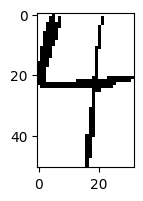

In [6]:
plt.figure(figsize=(2,2))
firstNumber = plt.imshow(segmentedImages[0], cmap='gray')
plt.show()

# (2) CNN Classifier

Train, Evaluate, and Save our Model (skip if already trained and saved)



In [7]:
# please see cnn.ipynb for training of CNN 

Load Our Model

In [8]:
# load our model

# replace with the path to your .h5 file on Google Drive OR simply load the .h5 file if you are not running this on Colab
modelFileName = 'cnn_v2/cnn_v2.h5'
model_path = folder_path + '/' + modelFileName

# load the model
classifier = load_model(model_path)


Visualize Structure of our model

In [9]:
#Visualizing the model
classifier.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                 

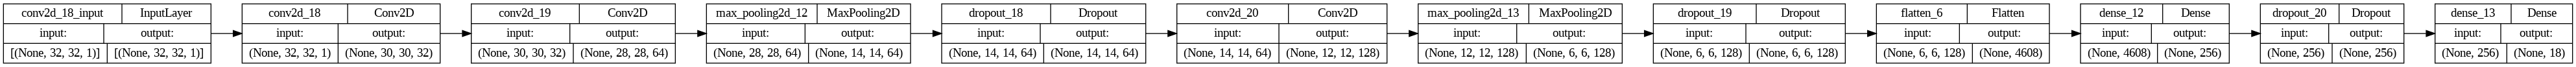

In [10]:
plot_model(classifier, to_file='classifier.png', show_shapes=True, rankdir='LR')

Run our model on our segmented images

In [11]:
# resize images
def resize_and_stretch(img, target_size=(32,32), stretch_margin=0.20):
    # convert the image to grayscale if it's in color
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # first, resize the image while keeping the aspect ratio
    original_height, original_width = img.shape[:2]
    ratio = min(target_size[0]/original_height, target_size[1]/original_width)
    new_size = (int(original_width*ratio), int(original_height*ratio))
    img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

    # if the image is still too small, stretch it up to 20% to reach the target size
    if img.shape[0] < target_size[0] or img.shape[1] < target_size[1]:
        stretch_ratio = min(target_size[0]/img.shape[0], target_size[1]/img.shape[1])
        stretch_ratio = min(stretch_ratio, 1 + stretch_margin)
        new_size = (int(img.shape[1]*stretch_ratio), int(img.shape[0]*stretch_ratio))
        img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

    # finally, if the image is still too small (due to the stretch limit), pad it to reach the target size
    delta_w = target_size[1] - img.shape[1]
    delta_h = target_size[0] - img.shape[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)

    return img

In [12]:
# Resize each image in segmentedImages
inputImages = [resize_and_stretch(img, target_size=(32,32)) for img in segmentedImages]

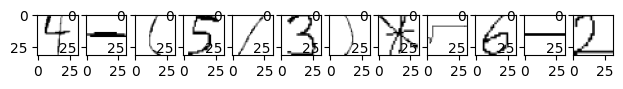

In [13]:
plt.figure(figsize=(20, 10))  # Change the figure size as per your requirement

for i, img in enumerate(inputImages):
    plt.subplot(1, len(img), i+1)
    plt.imshow(img, cmap='gray')  # Display image in grayscale

plt.show()


In [14]:
predictions = []

for img in inputImages:
    # add an extra dimension for the channels and normalize the image
    img = np.expand_dims(img, axis=-1)
    img = img.astype('float32') / 255.0
    # add an extra dimension for the batch size
    img = np.expand_dims(img, axis=0)
    predictions.append(classifier.predict(img))


1/1 [==============================] - 0s 26ms/step


In [15]:
# decode predictions

fileName = 'cnn_v2/label_encoder.pkl'
pkl_file = open(folder_path + '/' + fileName, 'rb')
le = pickle.load(pkl_file) 
pkl_file.close()

In [16]:
mapper = {}
for index, label in enumerate(le.classes_):
    print(f'Index: {index}, Label: {label}')
    mapper[index] = label

Index: 0, Label: (
Index: 1, Label: )
Index: 2, Label: +
Index: 3, Label: -
Index: 4, Label: /
Index: 5, Label: 0
Index: 6, Label: 1
Index: 7, Label: 2
Index: 8, Label: 3
Index: 9, Label: 4
Index: 10, Label: 5
Index: 11, Label: 6
Index: 12, Label: 7
Index: 13, Label: 8
Index: 14, Label: 9
Index: 15, Label: X
Index: 16, Label: \ast
Index: 17, Label: \sqrt{}


In [17]:
predictions[2][0]

array([9.36536372e-01, 1.03447448e-04, 7.31196415e-05, 9.21283117e-06,
       2.30618343e-02, 2.02674372e-03, 2.20655184e-02, 8.95651639e-04,
       1.54111709e-04, 1.37130846e-03, 1.15856536e-04, 1.09706558e-02,
       8.65628885e-04, 1.24268176e-04, 2.20209608e-04, 1.86568286e-05,
       3.47934542e-06, 1.38396909e-03], dtype=float32)

prediction for image number 0
Probability that its ( = 2.53514e-07
Probability that its ) = 2.0822273e-09
Probability that its + = 0.00010252856
Probability that its - = 2.0298583e-06
Probability that its / = 1.2638673e-05
Probability that its 0 = 5.029942e-07
Probability that its 1 = 5.7032685e-06
Probability that its 2 = 1.6084238e-07
Probability that its 3 = 1.6546339e-05
Probability that its 4 = 0.99625176
Probability that its 5 = 0.00334269
Probability that its 6 = 0.00012071787
Probability that its 7 = 7.0358633e-06
Probability that its 8 = 1.24219805e-05
Probability that its 9 = 0.00011326927
Probability that its X = 1.1876393e-06
Probability that its \ast = 2.6860214e-06
Probability that its \sqrt{} = 7.838195e-06


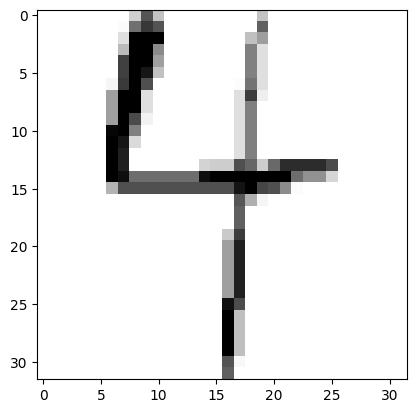

In [18]:
imgNum = 0
plt.imshow(inputImages[imgNum],  cmap=plt.cm.gray)
print("prediction for image number", imgNum)
for i in range(len(predictions[imgNum][0])):
  print("Probability that its " + mapper[i] + " =", predictions[imgNum][0][i])

In [19]:
# get the class with the highest probability for each prediction
predicted_classes = [np.argmax(pred[0]) for pred in predictions]

# use the inverse transform of the label encoder to get the original labels
predicted_labels = le.inverse_transform(predicted_classes)

predicted_labels

array(['4', '-', '(', '5', '/', '3', ')', '\\ast', '\\sqrt{}', '6', '-',
       '2'], dtype='<U7')

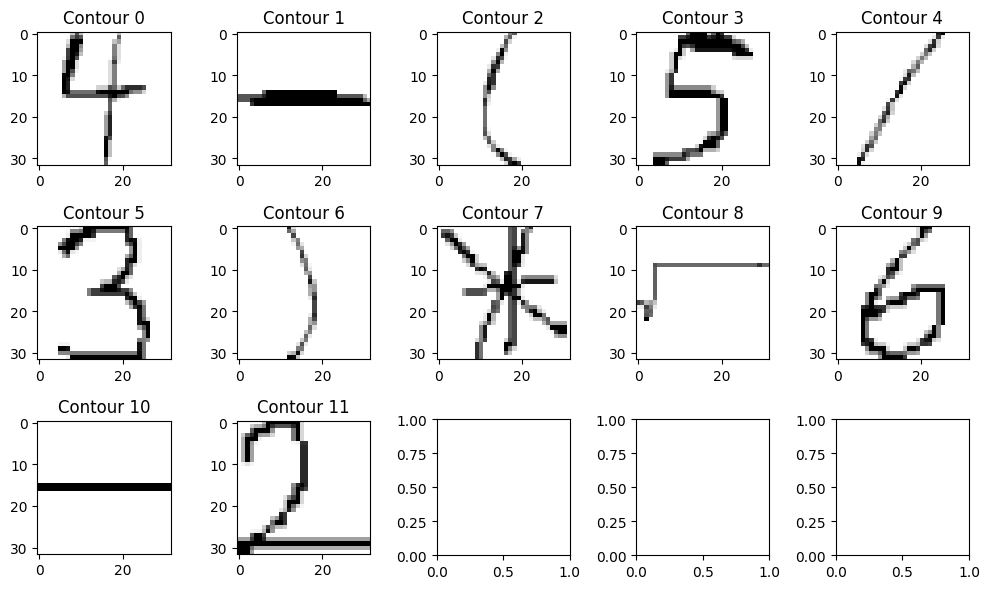

In [20]:
imgSeg.plotSegmentedImages(inputImages)

# (3) Parse

We define our square root finding technique

In [21]:
def rootWrap(predicted_labels, boundingBoxes):
  rootWrappers = {}

  currentSqrtStartIndex = 0
  sqrtBounds = (0, 0)
  currentWrapper = []

  for i in range(len(predicted_labels)):
    # we are currently inside a squareroot
    if(sqrtBounds != (0,0)):
      currentBound = (boundingBoxes[i][0], boundingBoxes[i][0] + boundingBoxes[i][2])

      # check if current symbol belongs inside square root bounds
      if(currentBound[0] >= sqrtBounds[0] and currentBound[1] <= sqrtBounds[1]):
        print("Added current bound of (" + str(currentBound[0]), str(currentBound[1]) + ")" )
        currentWrapper.append(i)
      else:
        rootWrappers[currentSqrtStartIndex] = currentWrapper.copy()
        currentWrapper.clear()
        sqrtBounds = (0,0)

    if(predicted_labels[i] == "\\sqrt{}"):
      currentSqrtStartIndex = i
      sqrtBounds = (boundingBoxes[i][0], boundingBoxes[i][0] + boundingBoxes[i][2]) 
      print("A square root found at index", i, "has bounds: (" + str(sqrtBounds[0]), str(sqrtBounds[1])+")")

  if(sqrtBounds != (0,0) and currentWrapper != []):
    rootWrappers[currentSqrtStartIndex] = currentWrapper.copy()
  
  return rootWrappers

In [22]:
rootWrappers = rootWrap(predicted_labels, boundingBoxes)

A square root found at index 8 has bounds: (215 300)
Added current bound of (239 252)
Added current bound of (255 267)
Added current bound of (269 288)


In [23]:

def parse(predicted_labels):
  parsed = list(predicted_labels.copy())

  for i in range(len(predicted_labels)):
    currLabel = predicted_labels[i]
    if(currLabel == "\\ast"):
      parsed[i] = "*"
    if(currLabel == "\\sqrt{}"):
      parsed[i] = "sqrt("
      endIndex = i + len(rootWrappers[i]) + 1
      parsed.insert(endIndex, ')')
  
  return parsed

In [24]:
parsed = parse(predicted_labels)

# (4) Solve

We implement our solver and many different evaluation methods
* We develop solvers that are less prone to mistakes and solvers that are more prone to mistakes (so they assume the expression is perfectly written)
* We will use the latter during demo and assume that the expression is perfect, i.e., does not contain misplaces ( ). Otherwise it will fail to run a proper expression as expected

In [25]:
from sympy import *
from sympy import parse_expr
from sympy import parse_expr, symbols, sqrt
from sympy.parsing.sympy_parser import transformations
from sympy.parsing.sympy_parser import standard_transformations
from sympy.parsing.sympy_parser import implicit_multiplication
from sympy.parsing.sympy_parser import function_exponentiation
from sympy import symbols
from sympy import Eq
from sympy.solvers import solve

# this redundant to importing symbol
from sympy.abc import x, y, z

print(transformations)

def rewrite_expression(expression):
  new_expression = []
  find_expression = False
  previous_expression = None
  symbols = "+-*/"

  for char in expression:
    # adds a multiplication if it is a digit followed by a parentheses 
    if previous_expression != None and previous_expression.isdigit() and char == "(":
      new_expression.append("*")
    
    # adds a power if it is a variable followed
    if previous_expression != None and previous_expression.isalpha() and char.isdigit():
      new_expression.append("**")
    
    # adds parentheses for sqrt (assumes the closing is before a symbol)
    if char == "sqrt":
      new_expression.append("sqrt(")
      find_expression = True
      continue
    if find_expression and char in symbols:
      new_expression.append(")")
      find_expression = False
    
    # appends character into new expression
    new_expression.append(char)
    previous_expression = char
  return new_expression

def transform_to_equation(expression):
  transformations = standard_transformations + (implicit_multiplication,) + (function_exponentiation,)
  concat_expression = "".join(expression) 
  left, right = concat_expression.split("=")
  left_expression = parse_expr(left, transformations=transformations, evaluate = False)
  right_expression = parse_expr(right, transformations=transformations, evaluate = False)
  return left_expression, right_expression


def evaluate2(expression):
  # evaluate a simple expression
  if not("=" in expression):
    try:
        expression = rewrite_expression(expression)
        concat_expression = "".join(expression)
        return eval(concat_expression)
    except (NameError, SyntaxError, TypeError):
        print("Failed to Evaluate Expression")
        return None
  
  # evaluate an equation
  expression = rewrite_expression(expression)
  left, right = transform_to_equation(expression)
  equation = Eq(left, right)

# assumes perfect 
def evaluate3(expression):
    # first, convert the list to a string
    str_expr = ''.join(expression)
    
    # then, parse the string as a sympy expression
    sympy_expr = sympify(str_expr)
    
    # finally, evaluate the sympy expression
    result = sympy_expr.evalf()
    
    return result

0: lambda_notation
1: auto_symbol
2: repeated_decimals
3: auto_number
4: factorial_notation
5: implicit_multiplication_application
6: convert_xor
7: implicit_application
8: implicit_multiplication
9: convert_equals_signs
10: function_exponentiation
11: rationalize


Test the parser and evaluate

In [27]:
print(parsed, '=', evaluate3(parsed))

['4', '-', '(', '5', '/', '3', ')', '*', 'sqrt(', '6', '-', '2', ')'] = 0.666666666666667


# FOR MORE TESTING PURPOSES

In [29]:
imageFolder = 'testSegmentImages'
fileName = "test_med2.png"
filePath = folder_path + '/' + imageFolder + '/' + fileName

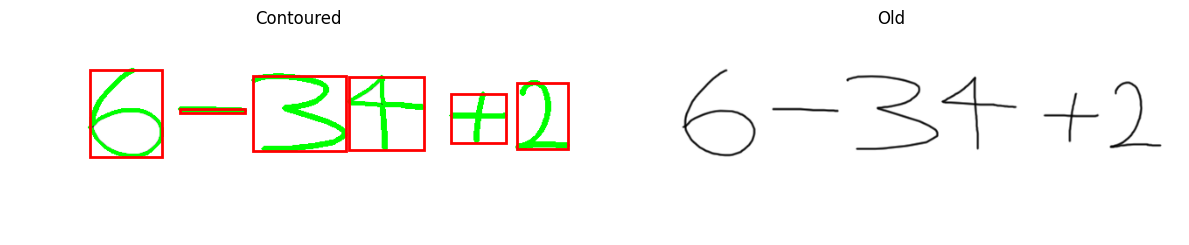

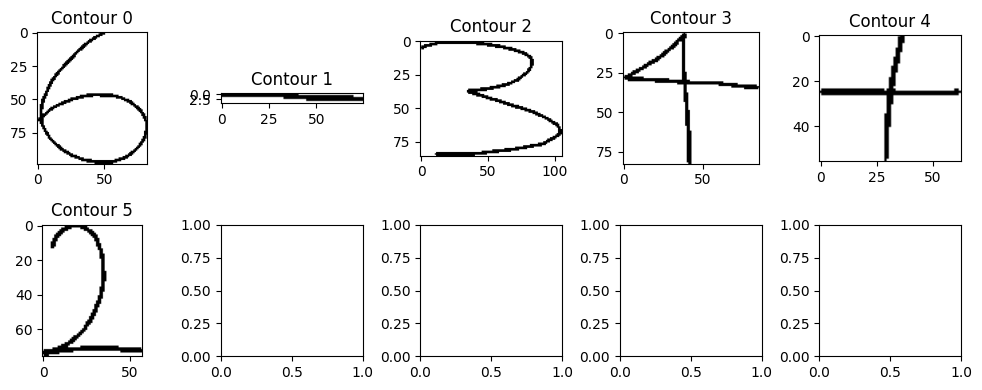

Bounding boxes
Segment 1: (91, 43, 83, 99)
Segment 2: (194, 87, 75, 5)
Segment 3: (278, 49, 106, 86)
Segment 4: (387, 51, 86, 83)
Segment 5: (504, 70, 63, 56)
Segment 6: (580, 57, 58, 76)
Boundary boxes are : (x,y,w,h) = (x_1, y_1, x_2 = x_1+w, y_1+h) where x_1 = left-most x, y_1 = left-most y, etc.


In [30]:
# check if img exists
image = cv2.imread(filePath)
if image is None:
  print("Check path again:", filePath)
  raise Exception("Image does not exist / failed to load")

# run image segment
imgSeg = imageSegment()
oldImage, contouredImage, segmentedImages, boundingBoxes = imgSeg.segmentationModel(filePath)

# plot before after
imgSeg.plotBeforeAfter(oldImage, contouredImage, boundingBoxes)

# plot the segmented images
imgSeg.plotSegmentedImages(segmentedImages)

# print out the bounding box details
imgSeg.boundingBoxDetails(boundingBoxes)

print("Boundary boxes are : (x,y,w,h) = (x_1, y_1, x_2 = x_1+w, y_1+h) where x_1 = left-most x, y_1 = left-most y, etc.")

In [31]:
# Resize each image in segmentedImages
inputImages = [resize_and_stretch(img, target_size=(32,32)) for img in segmentedImages]


In [32]:
# predict

predictions = []


for img in inputImages:
    # add an extra dimension for the channels and normalize the image
    img = np.expand_dims(img, axis=-1)
    img = img.astype('float32') / 255.0
    # add an extra dimension for the batch size
    img = np.expand_dims(img, axis=0)
    predictions.append(classifier.predict(img))


1/1 [==============================] - 0s 131ms/step


In [33]:
# get the class with the highest probability for each prediction
predicted_classes = [np.argmax(pred[0]) for pred in predictions]

# use the inverse transform of the label encoder to get the original labels
predicted_labels = le.inverse_transform(predicted_classes)

predicted_labels

array(['6', '-', '3', '4', '+', '2'], dtype='<U7')

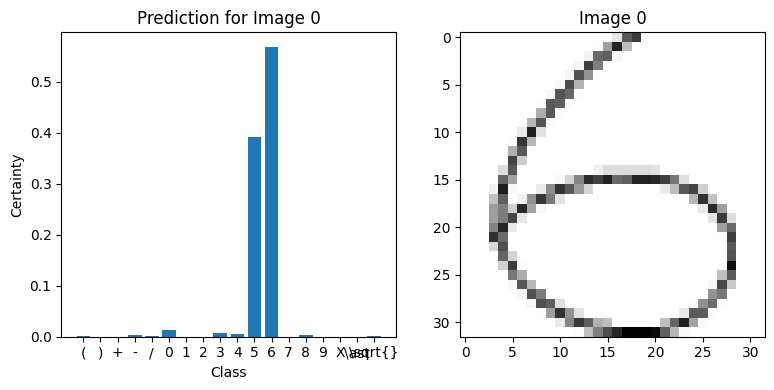

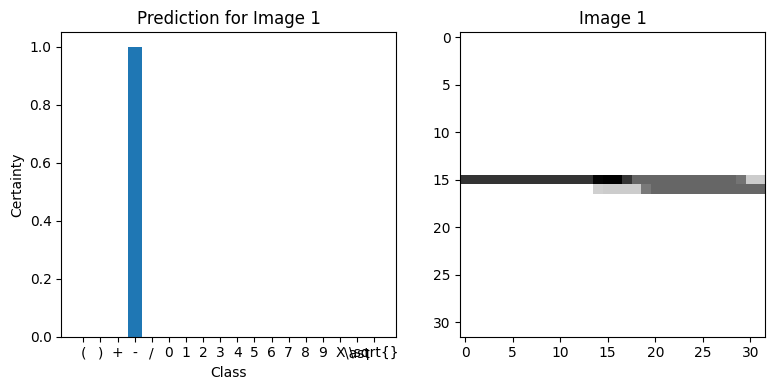

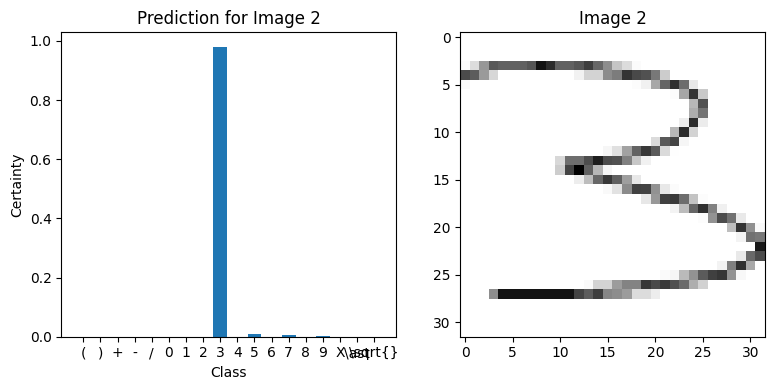

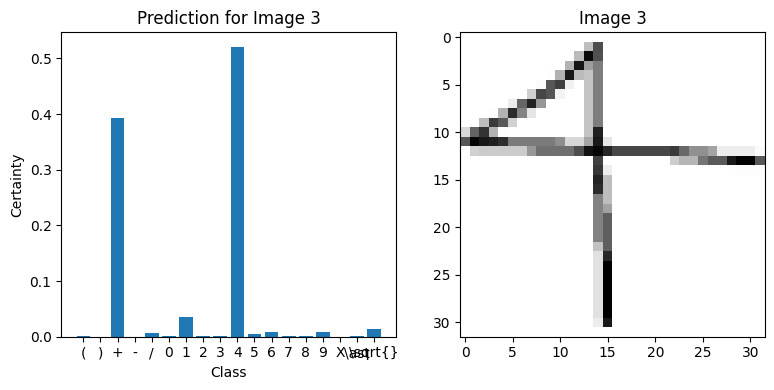

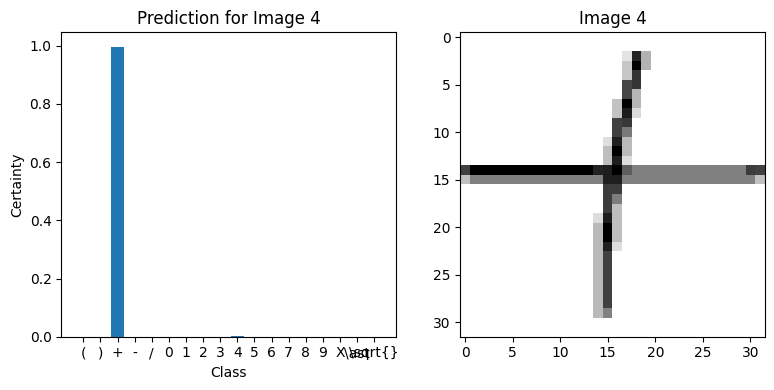

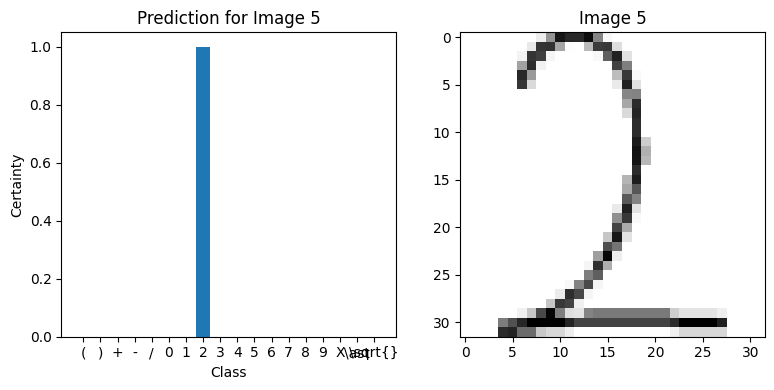

In [34]:
import matplotlib.pyplot as plt

# Get the names of the classes from the label encoder
class_names = le.classes_

# Create a bar chart of the prediction probabilities
for imageIndex in range(len(predictions)):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the predicted probabilities as a bar chart
    axs[0].bar(class_names, predictions[imageIndex][0])
    axs[0].set_title(f"Prediction for Image {imageIndex}")
    axs[0].set_xlabel("Class")
    axs[0].set_ylabel("Certainty")

    # Plot the image on the right
    axs[1].imshow(inputImages[imageIndex], cmap='gray')
    axs[1].set_title(f"Image {imageIndex}")
    # axs[1].axis('off')  # Hide the axes on the image plot

    plt.tight_layout()
    plt.show()


In [35]:
predictions[0][0]

array([2.35128216e-03, 3.66870540e-06, 1.12070575e-05, 2.62192683e-03,
       1.70445500e-03, 1.35909282e-02, 7.33594861e-05, 5.17530534e-05,
       7.65014859e-03, 6.20301533e-03, 3.92278254e-01, 5.68262815e-01,
       4.09433123e-05, 3.70727968e-03, 2.19521200e-04, 2.14632910e-05,
       3.03234037e-06, 1.20497460e-03], dtype=float32)

Parse

In [36]:
rootWrappers = rootWrappers = rootWrap(predicted_labels, boundingBoxes)
parsed = parse(predicted_labels)

Solve

In [37]:
# test
print(parsed, '=', evaluate3(parsed))

['6', '-', '3', '4', '+', '2'] = -26.0000000000000
